# Shared Memory Parallelism Using OpenMP
We want to use OpenMP to enable parallel execution of our codes. If multiple workers can do the same job, execution will be sped up.

In [1]:
pygmentize omp_examples/a01-parallel.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const *argv[]) {
  // this is a sequential region
  srand(712);
  double a = rand() % 100;
  std::cout << std::to_string(a) + "\n\n";

  // this is a parallel region
#pragma omp parallel
  {
    double b = rand() % 100;
    std::cout << std::to_string(b) + "\n";
  }

  // this is a sequential region
  std::cout << "\nthis is a sequential region again\n";

  std::cout << std::flush;
}


We need to tell the compiler that our program contains OpenMP pragmas with the `-fopenmp` option.

In [2]:
g++ omp_examples/a01-parallel.cpp -fopenmp -o parallel.out

Now we can run the generated executable.

In [3]:
./parallel.out

22.000000

12.000000
83.000000
81.000000
49.000000
38.000000
76.000000
31.000000
3.000000
48.000000
2.000000
93.000000
54.000000
97.000000
25.000000
37.000000
56.000000
42.000000
13.000000
89.000000
51.000000
45.000000
15.000000
59.000000
65.000000

this is a sequential region again


<div class="alert alert-block alert-warning">
    We see that each worker is entering the parallel region and executes the code independent of the other workers.<br>
    If we repeat the same block multiple times we see that there is no deterministic answer as the order changes. We see thought that the numbers printed are always the same
</div>    

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> Can you explain why the numbers are the same but the order is jumbled up?
    
<b>2.</b> Why do you see the number of outputs?
</div>

1: We are seeding the random number generator, so we have consistent output. Every thread writes the same number every execution. There is no way of guaranteeing the oder of operations though.

2: The default on daint is that we use all 24 (virtual) cores available. 

## Infos About the Region
OpenMP allows to get the information about number of threads present in each parallel region

In [4]:
pygmentize omp_examples/a02-infos.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {
#pragma omp parallel
  {
    int size = omp_get_num_threads();
    int rank = omp_get_thread_num();
#pragma omp critical(output)
    std::cout << "I am thread " << rank << " of a total of " << size << " threads" << std::endl;
  }
}


In [5]:
g++ omp_examples/a02-infos.cpp -fopenmp -o infos.out && ./infos.out

I am thread 12 of a total of 24 threads
I am thread 9 of a total of 24 threads
I am thread 21 of a total of 24 threads
I am thread 14 of a total of 24 threads
I am thread 19 of a total of 24 threads
I am thread 1 of a total of 24 threads
I am thread 3 of a total of 24 threads
I am thread 15 of a total of 24 threads
I am thread 23 of a total of 24 threads
I am thread 4 of a total of 24 threads
I am thread 11 of a total of 24 threads
I am thread 20 of a total of 24 threads
I am thread 13 of a total of 24 threads
I am thread 8 of a total of 24 threads
I am thread 18 of a total of 24 threads
I am thread 6 of a total of 24 threads
I am thread 5 of a total of 24 threads
I am thread 17 of a total of 24 threads
I am thread 0 of a total of 24 threads
I am thread 16 of a total of 24 threads
I am thread 2 of a total of 24 threads
I am thread 7 of a total of 24 threads
I am thread 22 of a total of 24 threads
I am thread 10 of a total of 24 threads


<div class="alert alert-block alert-warning">
    We can inspect the current thread number and the total number of threads via intrinsics
</div>    

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> Can you think of a good reason why this information might be useful?
    
</div>

3: 
- Each thread doing local work and storing it in it's own element of an array
- Threads working on local work having to communicate with thread that are neighboring

## Setting the Number of Threads
We can do this either on each parallel region or with an environment variable

In [6]:
pygmentize omp_examples/a03-threadnum.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

#pragma omp parallel num_threads(2)
  {
    int size = omp_get_num_threads();
    int rank = omp_get_thread_num();
#pragma omp critical(output)
    std::cout << "I am rank " << rank << " of a total of " << size << " threads" << std::endl;
  }
}


In [7]:
g++ omp_examples/a03-threadnum.cpp -fopenmp -o threadnum.out && ./threadnum.out

I am rank 0 of a total of 2 threads
I am rank 1 of a total of 2 threads


<div class="alert alert-block alert-warning">
    We can set the number of threads with the <code>num_threads</code> keyword for parallel regions
</div>

In [8]:
OMP_NUM_THREADS=4 ./infos.out

I am thread 0 of a total of 4 threads
I am thread 2 of a total of 4 threads
I am thread 3 of a total of 4 threads
I am thread 1 of a total of 4 threads


<div class="alert alert-block alert-warning">
    We can set the number of threads to use when nothing is specified with the <code>OMP_NUM_THREADS</code> environment variable.
</div>

In [9]:
OMP_NUM_THREADS=4 ./threadnum.out

I am rank 0 of a total of 2 threads
I am rank 1 of a total of 2 threads


<div class="alert alert-block alert-warning">
    We see that <code>num_threads</code> takes presedence over <code>OMP_NUM_THREADS</code>
</div>

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>4.</b> Why do you think num_threads is higher up in the order of precedence?<br>
<b>5.</b> Why do we need to ways of controlling this are these two ways fulfilling the same purpose?
</div>

<b>4.</b> We can optimize certain codes an fixed numbers of workers. If we have such a code we do not want the environment to overwrite this.<br>
<b>5.</b> We have more fine-grained control over the number of threads on a per-block basis compared to a global default value. 
    

## Parallel Loops
Since loops are such an important concept to parallelize, there is a special directive for it.

In [10]:
pygmentize omp_examples/a04-loops.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

// parallel loop
#pragma omp parallel for
  for(int i = 0; i < 10; ++i) {
#pragma omp critical(output)
    std::cout << "This is iteration " << i << " executed from thread " << omp_get_thread_num()
              << std::endl;
  }
}


In [12]:
g++ omp_examples/a04-loops.cpp -fopenmp -o loops.out

In [13]:
OMP_NUM_THREADS=4 ./loops.out

This is iteration 0 executed from thread 0
This is iteration 1 executed from thread 0
This is iteration 8 executed from thread 3
This is iteration 9 executed from thread 3
This is iteration 2 executed from thread 0
This is iteration 6 executed from thread 2
This is iteration 7 executed from thread 2
This is iteration 3 executed from thread 1
This is iteration 4 executed from thread 1
This is iteration 5 executed from thread 1


<div class="alert alert-block alert-warning">
    We see that the loop order is not preserved, threads take diffent amout of iterations and are not sorted
</div>

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>6.</b> Since this is an existing concept it has it's applications. Can you think of a simple example where the loop order does not matter? Can you also think of one where an unordered loop will break the program flow?<br>
    
</div>

6a: Any stencil computation. (The output is not the input)

6b: For example the circuit value problem: For a set of circuits and a given input, generate the output.

In [14]:
OMP_NUM_THREADS=12 ./loops.out

This is iteration 0 executed from thread 0
This is iteration 6 executed from thread 6
This is iteration 1 executed from thread 1
This is iteration 4 executed from thread 4
This is iteration 5 executed from thread 5
This is iteration 9 executed from thread 9
This is iteration 3 executed from thread 3
This is iteration 7 executed from thread 7
This is iteration 8 executed from thread 8
This is iteration 2 executed from thread 2


<div class="alert alert-block alert-warning">
    If more threads than loop iterations are available, only the first set of threads is used
</div>

## Scheduling
<div class="alert alert-block alert-danger">
This is an important concept to understand but is not necessarily used in our example
</div>

Controlling the loop execution with the `schedule` directive might be important for performance. Since the work is oftentimes similar in weather and climate codes this is not super important for our example but is still a concept worth knowing.

In [15]:
pygmentize omp_examples/a05-schedule.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

  std::cout << "schedule(static, 2)" << std::endl;
#pragma omp parallel for schedule(static, 2)
  for(std::size_t i = 0; i < 10; ++i) {
#pragma omp critical(output)
    std::cout << "This is iteration " << i << " executed from thread " << omp_get_thread_num()
              << std::endl;
  }
  std::cout << "schedule(static, 1)" << std::endl;
#pragma omp parallel for schedule(static, 1)
  for(std::size_t i = 0; i < 10; ++i) {
#pragma omp critical(output)
    std::cout << "This is iteration " << i << " executed from thread " << omp_get_thread_num()
              << std::endl;
  }
}


In [17]:
g++ omp_examples/a05-schedule.cpp -fopenmp -o schedule.out

In [18]:
OMP_NUM_THREADS=2 ./schedule.out

schedule(static, 2)
This is iteration 0 executed from thread 0
This is iteration 1 executed from thread 0
This is iteration 4 executed from thread 0
This is iteration 5 executed from thread 0
This is iteration 8 executed from thread 0
This is iteration 9 executed from thread 0
This is iteration 2 executed from thread 1
This is iteration 3 executed from thread 1
This is iteration 6 executed from thread 1
This is iteration 7 executed from thread 1
schedule(static, 1)
This is iteration 1 executed from thread 1
This is iteration 3 executed from thread 1
This is iteration 5 executed from thread 1
This is iteration 7 executed from thread 1
This is iteration 9 executed from thread 1
This is iteration 0 executed from thread 0
This is iteration 2 executed from thread 0
This is iteration 4 executed from thread 0
This is iteration 6 executed from thread 0
This is iteration 8 executed from thread 0


<div class="alert alert-block alert-warning">
    Static scheduling allows us to assign chunks of the iteration to the same thread
</div>

## Variable Scoping
We try to understand how variables are scoped, who owns them at which parts of the code and who can see effects of writing them.

In [19]:
pygmentize omp_examples/a06-scoping.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

  int myvar = -1;
#pragma omp parallel for num_threads(3)
  for(std::size_t i = 0; i < 10; ++i) {
    myvar = i;
#pragma omp critical(output)
    std::cout << "i is " << i << " and myvar is " << myvar << std::endl;
  }

  std::cout << "myvar: " << myvar << std::endl;
}


In [21]:
g++ omp_examples/a06-scoping.cpp -fopenmp -o scoping.out

In [27]:
./scoping.out

i is 0 and myvar is 7
i is 7 and myvar is 1
i is 4 and myvar is 8
i is 5 and myvar is 5
i is 6 and myvar is 6
i is 8 and myvar is 6
i is 1 and myvar is 9
i is 9 and myvar is 2
i is 2 and myvar is 2
i is 3 and myvar is 3
myvar: 3


<div class="alert alert-block alert-warning">
    We see that shared variables can cause race conditions
</div>

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>7.</b> Run the above code 5 times. What do you observe?<br>
<b>8.</b> Why is the code above problematic? Is what we're doing here still compatible with the Turing Machine way of modelling computers?
    
</div>

<b>TODO</b><br>
7: The output in the end is not deterministic.

8: We have no way of controlling which thread is the last to write output. So we have some inherit randomness and are therefore no longer fulfilling the requirement of having deterministic output from inputs.

The private directive allows each thread to have a copy of a variable: 

In [28]:
pygmentize omp_examples/a07-private.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

  int myvar = -1;
#pragma omp parallel for private(myvar)
  for(std::size_t i = 0; i < 10; ++i) {
#pragma omp critical(output)
    std::cout << "before writing:\n  i is " << i << " and myvar is " << myvar << std::endl;
    myvar = i;
#pragma omp critical(output)
    std::cout << "after writing:\n\ti is " << i << " and myvar is " << myvar << std::endl;
  }
  std::cout << "myvar: " << myvar << std::endl;
}


In [29]:
g++ omp_examples/a07-private.cpp -fopenmp -o private.out

In [30]:
OMP_NUM_THREADS=10 ./private.out

before writing:
  i is 0 and myvar is 0
before writing:
  i is 4 and myvar is 0
after writing:
	i is 4 and myvar is 4
after writing:
	i is 0 and myvar is 0
before writing:
  i is 3 and myvar is 0
after writing:
	i is 3 and myvar is 3
before writing:
  i is 6 and myvar is 0
after writing:
	i is 6 and myvar is 6
before writing:
  i is 2 and myvar is 0
after writing:
	i is 2 and myvar is 2
before writing:
  i is 1 and myvar is 0
after writing:
	i is 1 and myvar is 1
before writing:
  i is 7 and myvar is 0
after writing:
	i is 7 and myvar is 7
before writing:
  i is 5 and myvar is 0
after writing:
	i is 5 and myvar is 5
before writing:
  i is 8 and myvar is 0
after writing:
	i is 8 and myvar is 8
before writing:
  i is 9 and myvar is 0
after writing:
	i is 9 and myvar is 9
myvar: -1


<div class="alert alert-block alert-warning">
    We see:
    <ul>
        <li>Private variables are always empty when coming in to the parallel regions</li>
        <li>Private variables do not cause race conditions</li>
        <li>The values in private variables are lost after exiting the parallel region</li>
    </ul>
</div>

shared is the default but can also be stated explicitly

In [31]:
pygmentize omp_examples/a08-shared.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

  int myvar = -1;
#pragma omp parallel for shared(myvar)
  for(std::size_t i = 0; i < 10; ++i) {
#pragma omp critical(output)
    std::cout << "before writing:\ni is " << i << " and myvar is " << myvar << std::endl;
    myvar = i;
#pragma omp critical(output)
    std::cout << "after writing:\n   i is " << i << " and myvar is " << myvar << std::endl;
  }
  std::cout << "myvar: " << myvar << std::endl;
}


In [32]:
g++ omp_examples/a08-shared.cpp -fopenmp -o shared.out

In [33]:
OMP_NUM_THREADS=10 ./shared.out

before writing:
i is 2 and myvar is -1
before writing:
i is 1 and myvar is 2
after writing:
   i is 1 and myvar is 1
before writing:
i is 0 and myvar is 1
after writing:
   i is 0 and myvar is 0
before writing:
i is 7 and myvar is 0
after writing:
   i is 7 and myvar is 7
after writing:
   i is 2 and myvar is 7
before writing:
i is 9 and myvar is 7
before writing:
i is 6 and myvar is 9
before writing:
i is 3 and myvar is 6
after writing:
   i is 6 and myvar is 3
after writing:
   i is 3 and myvar is 3
before writing:
i is 8 and myvar is 3
after writing:
   i is 8 and myvar is 8
before writing:
i is 5 and myvar is 8
after writing:
   i is 9 and myvar is 5
before writing:
i is 4 and myvar is 5
after writing:
   i is 5 and myvar is 4
after writing:
   i is 4 and myvar is 4
myvar: 4


<div class="alert alert-block alert-warning">
    We find a way to explicitly use shared variables in parallel regions
</div>

## Special Regions
<div class="alert alert-block alert-danger">
This is an important concept to understand but is not necessarily used in our example
</div>

There are certain pieces of the code that might be more sensitive to how threads should be handling them, here are the options:

In [34]:
pygmentize omp_examples/a09-regions.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

#pragma omp parallel
  {
    int size = omp_get_num_threads();
    int rank = omp_get_thread_num();
#pragma omp single
    {
      std::cout << "thread " << rank << " is present in single" << std::endl;
      std::cout << "and the size here is : " << omp_get_num_threads() << std::endl;
    }
#pragma omp master
    { std::cout << "thread " << rank << " is present in master" << std::endl; }
#pragma omp critical(somethingHard)
    { std::cout << "thread " << rank << " is present in critical" << std::endl; }
  }
}


In [35]:
g++ omp_examples/a09-regions.cpp -fopenmp -o regions.out && ./regions.out

thread 0 is present in single
and the size here is : 24
thread 0thread  is present in master21 is present in critical

thread 9 is present in critical
thread 19 is present in critical
thread 7 is present in critical
thread 12 is present in critical
thread 17 is present in critical
thread 5 is present in critical
thread 13 is present in critical
thread 4 is present in critical
thread 16 is present in critical
thread 11 is present in critical
thread 23 is present in critical
thread 18 is present in critical
thread 6 is present in critical
thread 0 is present in critical
thread 1 is present in critical
thread 2 is present in critical
thread 14 is present in critical
thread 10 is present in critical
thread 22 is present in critical
thread 8 is present in critical
thread 20 is present in critical
thread 15 is present in critical
thread 3 is present in critical


<div class="alert alert-block alert-warning">
    We learn that thread 0 is the only one entering <code>master</code>, only one thread ever enters <code>single</code> and every thread enters <code>critical</code>, but only one at a time
</div>

## What if parallel regions span multiple tasks
<div class="alert alert-block alert-danger">
This is an important concept to understand but is not necessarily used in our example
</div>

Depending on how parallelization was done there might be a need to let threads wait for each other. The `#pragma omp barrier` is used for that.

In [36]:
pygmentize omp_examples/a10-barrier.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

#pragma omp parallel num_threads(5)
  {
    int size = omp_get_num_threads();
    int rank = omp_get_thread_num();
#pragma omp critical(somethingHard)
    {
      std::string s = "thread " + std::to_string(rank) + " is present in critical1\n";
      std::cout << s;
    }
#pragma omp critical(somethingEasy)
    {
      std::string s = "thread " + std::to_string(rank) + " is present in critical2\n";
      std::cout << s;
    }
  }
}


In [37]:
g++ omp_examples/a10-barrier.cpp -fopenmp -o barrier.out && ./barrier.out

thread 0 is present in critical1
thread 0 is present in critical2
thread 3 is present in critical1
thread 3 is present in critical2
thread 2 is present in critical1
thread 2 is present in critical2
thread 1 is present in critical1
thread 1 is present in critical2
thread 4 is present in critical1
thread 4 is present in critical2


<div class="alert alert-block alert-warning">
    We learn that there is no guarantee on the execution order of different statements in a parallel block across threads
</div>

In [38]:
pygmentize omp_examples/a11-barrier.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

#pragma omp parallel num_threads(5)
  {
    int size = omp_get_num_threads();
    int rank = omp_get_thread_num();
#pragma omp critical(somethingHard)
    {
      std::string s = "thread " + std::to_string(rank) + " is present in critical1\n";
      std::cout << s;
    }
#pragma omp barrier
#pragma omp critical(somethingEasy)
    {
      std::string s = "thread " + std::to_string(rank) + " is present in critical2\n";
      std::cout << s;
    }
  }
}


In [39]:
g++ omp_examples/a11-barrier.cpp -fopenmp -o barrier2.out && ./barrier2.out

thread 0 is present in critical1
thread 1 is present in critical1
thread 3 is present in critical1
thread 4 is present in critical1
thread 2 is present in critical1
thread 4 is present in critical2
thread 2 is present in critical2
thread 0 is present in critical2
thread 1 is present in critical2
thread 3 is present in critical2


<div class="alert alert-block alert-warning">
    We learn that barriers help synchronize code
</div>

## Nowait
<div class="alert alert-block alert-danger">
This is an important concept to understand but is not necessarily used in our example
</div>

Certain OpenMP statements come with implicit barriers so `nowait` is the keyword to explicitly disable those

In [40]:
pygmentize omp_examples/a12-loops.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

#pragma omp parallel num_threads(3)
  {
    int size = omp_get_num_threads();
    int rank = omp_get_thread_num();
#pragma omp for
    for(int i = 0; i < 6; ++i) {
      std::string s = "loop 1, iteration" + std::to_string(i) + "\n";
      std::cout << s;
    }

#pragma omp for
    for(int i = 0; i < 6; ++i) {
      std::string s = "loop 2, iteration" + std::to_string(i) + "\n";
      std::cout << s;
    }
  }
}


In [41]:
g++ omp_examples/a12-loops.cpp -fopenmp -o loops.out && ./loops.out

loop 1, iteration0
loop 1, iteration1
loop 1, iteration4
loop 1, iteration5
loop 1, iteration2
loop 1, iteration3
loop 2, iteration4
loop 2, iteration5
loop 2, iteration2
loop 2, iteration3
loop 2, iteration0
loop 2, iteration1


<div class="alert alert-block alert-warning">
    We learn that loops synchrnoize afterwards
</div>

In [42]:
pygmentize omp_examples/a13-nowait.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

#pragma omp parallel num_threads(3)
  {
    int size = omp_get_num_threads();
    int rank = omp_get_thread_num();
#pragma omp for nowait
    for(int i = 0; i < 6; ++i) {
      std::string s = "loop 1, iteration " + std::to_string(i) + "\n";
      std::cout << s;
    }

#pragma omp for nowait
    for(int i = 0; i < 6; ++i) {
      std::string s = "loop 2, iteration " + std::to_string(i) + "\n";
      std::cout << s;
    }
  }
}


In [43]:
g++ omp_examples/a13-nowait.cpp -fopenmp -o nowait.out && ./nowait.out

loop 1, iteration 0
loop 1, iteration 4
loop 1, iteration 5
loop 2, iteration 4
loop 2, iteration 5
loop 1, iteration 1
loop 2, iteration 0
loop 2, iteration 1
loop 1, iteration 2
loop 1, iteration 3
loop 2, iteration 2
loop 2, iteration 3


<div class="alert alert-block alert-warning">
    We learn that the nowait keyword can remove synchonizaton
</div>

## Reductions
<div class="alert alert-block alert-danger">
This is an important concept to understand but is not necessarily used in our example
</div>

Since reductions are such an omnipresent motif, we do not want to implement it with critical / atomic every time, so there is a keyword for it:

In [44]:
pygmentize omp_examples/a14-reduction.cpp

#include <cstdlib>
#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {
  double sum;
#pragma omp parallel for reduction(+ : sum)
  for(std::size_t t = 0; t < 10;++t) {
    sum += t;
  }
    std::cout << sum<<std::endl;
}


In [45]:
g++ omp_examples/a14-reduction.cpp -fopenmp -o reduction.out && ./reduction.out

45


<div class="alert alert-block alert-warning">
    We learn about the reduction keyword
</div>

# Amdahl's law

We try to investigate the performance of a simple example, computing $\pi$ using the Leibniz formula:

$$1 - \frac{1}{3} + \frac{1}{5} - \frac{1}{7} + \frac{1}{9} ... = \frac{\pi}{4}$$

Our goal is to understand what might affect performance and how this is reflected in strong and weak scaling plots

## Strong Scaling

Understanding how much faster the code gets though parallelization

In [46]:
pygmentize omp_examples/b01-timing.cpp

#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

  int nThreads = atoi(argv[1]);
  omp_set_num_threads(nThreads);
  


  double tic = omp_get_wtime();

  int steps = 10000000;
  double sum;
#pragma omp parallel for reduction(+ : sum)
  for(std::size_t t = 0; t < steps; ++t) {
    sum += (1.0 - 2 * (t % 2)) / (2 * t + 1);
  }

  double toc = omp_get_wtime();

#pragma omp parallel
  {
    if(omp_get_thread_num() == 0)
      std::cout << omp_get_num_threads() << "\t" << toc - tic << std::endl;
  }

  return 0;
}


In [47]:
g++ -fopenmp omp_examples/b01-timing.cpp -o timing.out

In [48]:
./timing.out 1 > out.txt
./timing.out 2 >> out.txt
./timing.out 3 >> out.txt
./timing.out 4 >> out.txt
./timing.out 5 >> out.txt
./timing.out 6 >> out.txt
./timing.out 7 >> out.txt
./timing.out 8 >> out.txt
./timing.out 9 >> out.txt
./timing.out 10 >> out.txt
./timing.out 11 >> out.txt
./timing.out 12 >> out.txt

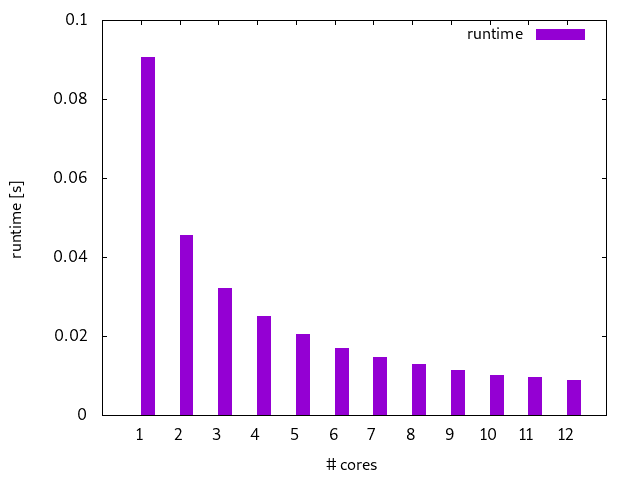

In [49]:
gnuplot -e "\
set terminal png; \
set style fill solid; \
set yrange[0:0.1]; \
set xlabel '# cores'; \
set ylabel 'runtime [s]'; \
plot 'out.txt' using 2: xtic(1) title 'runtime' with histogram \
" | display

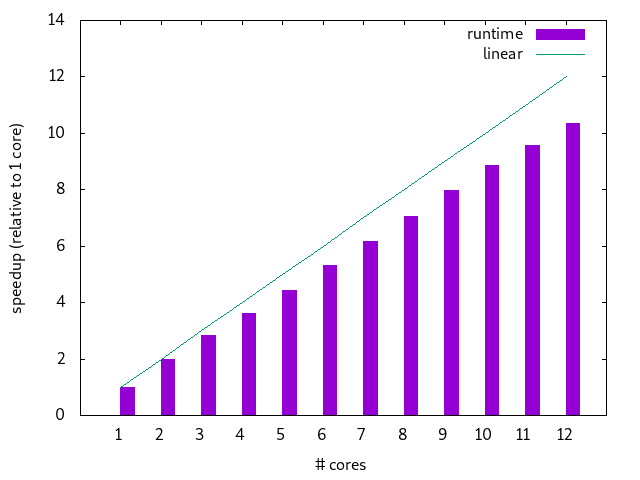

In [50]:
base=`head -1 out.txt | awk '{print $2}'`
gnuplot -e "\
set terminal png; \
set style fill solid; \
set yrange[0:14]; \
set xlabel '# cores'; \
set ylabel 'speedup (relative to 1 core)'; \
plot 'out.txt' using ($base/\$2): xtic(1) title 'runtime' with histogram, 
'out.txt' using :(\$1) title 'linear' with lines\
" | display

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>9.</b> Can you explain the performance numbers that we see here? What effects are in place?<br>    
</div>

We have a code that is not perfectly parallel - the actual reduction has a sequential part. So we can't scale 100% perfect.


## Weak scaling
Measuring the performance hit we get by increasing the problem size as well as the number of threads

In [51]:
pygmentize omp_examples/b02-weakscaling.cpp

#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

  int nThreads = atoi(argv[1]);
  int steps = 10000000 * nThreads;
  double sum;

  omp_set_num_threads(nThreads);

  double tic = omp_get_wtime();

#pragma omp parallel for reduction(+ : sum)
  for(std::size_t t = 0; t < steps; ++t) {
    sum += (1.0 - 2 * (t % 2)) / (2 * t + 1);
  }

  double toc = omp_get_wtime();

#pragma omp parallel
  {
    if(omp_get_thread_num() == 0)
      std::cout << omp_get_num_threads() << "\t" << toc - tic << std::endl;
  }

  return 0;
}


In [52]:
g++ -fopenmp omp_examples/b02-weakscaling.cpp -o weak.out

In [55]:
./weak.out 1 > weak.txt
./weak.out 2 >> weak.txt
./weak.out 4 >> weak.txt
./weak.out 8 >> weak.txt
./weak.out 12 >> weak.txt
./weak.out 18 >> weak.txt
./weak.out 20 >> weak.txt
./weak.out 24 >> weak.txt
./weak.out 30 >> weak.txt

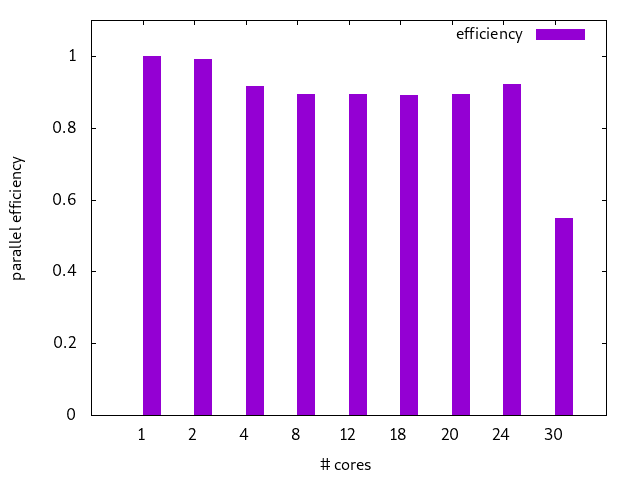

In [56]:
base=`head -1 weak.txt | awk '{print $2}'`
gnuplot -e "\
set terminal png; \
set style fill solid; \
set yrange[0:1.1]; \
set xlabel '# cores'; \
set ylabel 'parallel efficiency'; \
plot 'weak.txt' using ($base/\$2): xtic(1) title 'efficiency' with histogram, 
" | display

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>10.</b> Can you explain the performance numbers that we see here? What effects are in place?<br>
</div>

This program is bound by the computation done - so as soon as we hit more work than the number of virtual cores available we see a very significant dip


## Caching

Here we see the implication of caching in a multithreaded environment

In [57]:
pygmentize omp_examples/b03-caching.cpp

#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const* argv[]) {

  std::vector<double> input(10000000, 1);
  std::vector<double> output(10000000, 0);

  omp_set_num_threads(atoi(argv[1]));

  double tic = omp_get_wtime();

#pragma omp parallel for schedule(static, 1)
  for(int i = 0; i < input.size(); ++i) {
    output[i] = 2 * input[i];
    input[i] = 0;
  }

  double toc = omp_get_wtime();

#pragma omp parallel
  {
    if(omp_get_thread_num() == 0)
      std::cout << omp_get_num_threads() << "\t" << toc - tic << std::endl;
  }

  return 0;
}


In [58]:
g++ -fopenmp omp_examples/b03-caching.cpp -o caching.out

In [59]:
./caching.out 1 > caching.txt
./caching.out 2 >> caching.txt
./caching.out 4 >> caching.txt
./caching.out 8 >> caching.txt
./caching.out 12 >> caching.txt
./caching.out 13 >> caching.txt
./caching.out 20 >> caching.txt
./caching.out 24 >> caching.txt

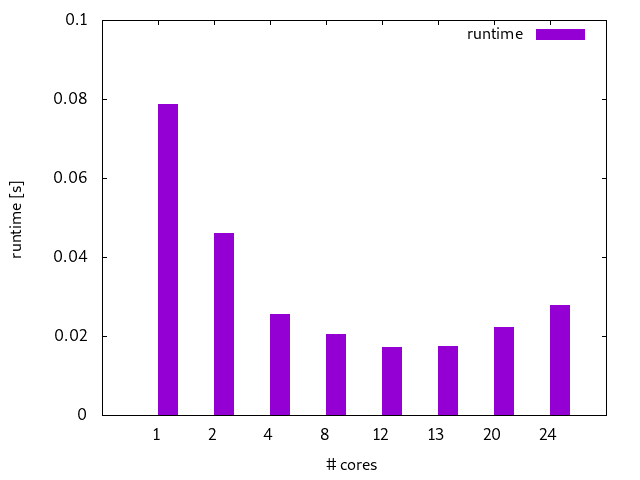

In [60]:
gnuplot -e "\
set terminal png; \
set style fill solid; \
set yrange[0:0.1]; \
set xlabel '# cores'; \
set ylabel 'runtime [s]'; \
plot 'caching.txt' using 2: xtic(1) title 'runtime' with histogram \
" | display

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>11.</b> Can you explain the performance numbers that we see here? What effects are in place?<br>
</div>

We see that we only have 12 caches available and since the program always invalidates the entire input cache-line after using it we want to not have more workers running than necessary. The optimal amount of workers is therefore where we use the most caches. 


In [61]:
pygmentize omp_examples/b04-caching_fast.cpp

#include <iostream>
#include <omp.h>
#include <vector>

int main(int argc, char const *argv[]) {

  std::vector<double> input(10000000, 1);
  std::vector<double> output(10000000, 0);

  omp_set_num_threads(atoi(argv[1]));

  double tic = omp_get_wtime();

#pragma omp parallel for schedule(static, 10000)
  for (int i = 0; i < input.size(); ++i) {
    output[i] = 2 * input[i];
    input[i] = 0;
  }

  double toc = omp_get_wtime();

#pragma omp parallel
  {
    if (omp_get_thread_num() == 0)
      std::cout << omp_get_num_threads() << "\t" << toc - tic << std::endl;
  }

  return 0;
}


In [66]:
g++ -fopenmp omp_examples/b06-caching_fast.cpp -o caching2.out

In [67]:
./caching2.out 1 > caching2.txt
./caching2.out 2 >> caching2.txt
./caching2.out 4 >> caching2.txt
./caching2.out 8 >> caching2.txt
./caching2.out 12 >> caching2.txt
./caching2.out 13 >> caching2.txt
./caching2.out 20 >> caching2.txt
./caching2.out 24 >> caching2.txt

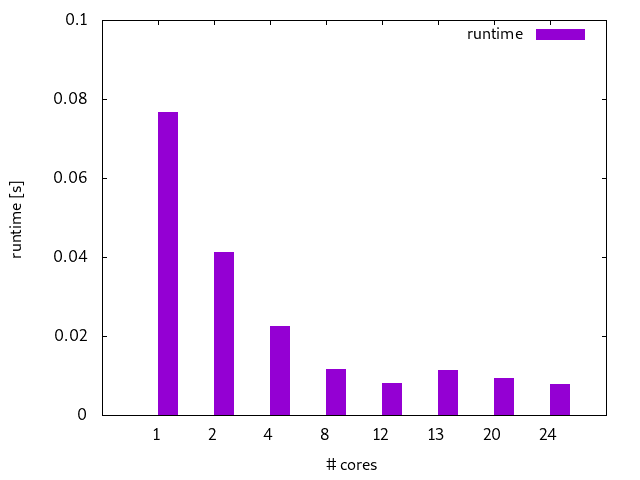

In [68]:
gnuplot -e "\
set terminal png; \
set style fill solid; \
set yrange[0:0.1]; \
set xlabel '# cores'; \
set ylabel 'runtime [s]'; \
plot 'caching2.txt' using 2: xtic(1) title 'runtime' with histogram \
" | display

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>12.</b> Can you explain the performance numbers that we see here? What effects are in place?<br>
</div>

Using a static scheduler allows us to keep entire cache-lines in our caches before they get invalidated. This allows for much better performance and scalability - using more than 12 threads is significantly better than it was before.

In [69]:
make clean_examples

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
